<a href="https://colab.research.google.com/github/MPGarg/Assignment-8/blob/main/EVA8_Assigment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
#!pip install -U albumentations
!pip install torch_lr_finder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch_lr_finder import LRFinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import files from GIT Hub

In [3]:
!git clone https://github.com/MPGarg/main_repo.git

Cloning into 'main_repo'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 82 (delta 13), reused 0 (delta 0), pack-reused 52
Unpacking objects: 100% (82/82), 31.32 KiB | 1.30 MiB/s, done.


# Custom ResNet class is imported

In [4]:
from main_repo.models import custom_resnet
from main_repo.models.custom_resnet import Custom_ResNet

# Import Other fuctions

In [5]:
from main_repo import main, utils
from main_repo.utils import *    
from main_repo.main import train, test, fit_model

# Assign device

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [7]:
view_model = Custom_ResNet().to(device)
summary(view_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
         Dropout2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
        Dropout2d-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Show sample images and Load dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


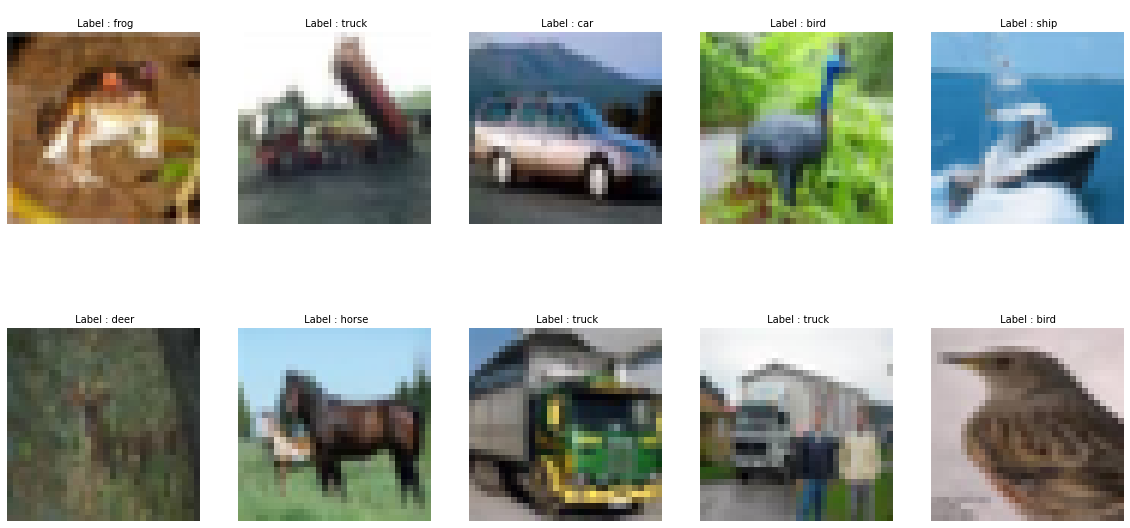

In [8]:
trainset_mod, trainloader_mod, testset_mod, testloader_mod,mean, std = process_dataset(visualize = 'X')     

In [9]:
print(mean)
print(std)

[0.4914, 0.4822, 0.4465]
[0.247, 0.2435, 0.2616]


# Find Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.84E-01


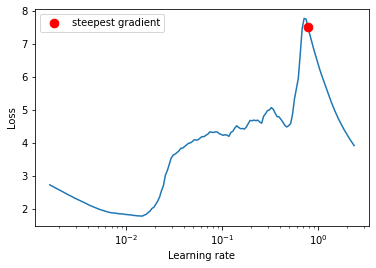

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa5e6bab040>, 0.7842822061337682)

In [10]:
import copy
model = Custom_ResNet().to(device)
model_exp = copy.deepcopy(model)
optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader_mod, end_lr=10, num_iter=200)
lr_finder.plot() 

In [11]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.014649713983072856


# Train & Test Model

In [12]:
#model = Custom_ResNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=ler_rate/10, momentum=0.9)
#max_lr is the maximum learning rate of OneCycleLR 
#the learning rate will increate from max_lr / div_factor to max_lr in the first pct_start * total_steps steps, 
#and decrease smoothly to max_lr / final_div_factor then.
#total_steps = epochs * steps_per_epoch
#total_steps = 24 * 98 = 2,352
#max_lr / div_factor = 0.01 / 10 = 0.001
#pct_start * total_steps = 0.002 * 2,352 = 4.704
#max_lr / final_div_factor = 0.01 / 100 = 0.00001
#final_div_factor (float) – Determines the minimum learning rate via min_lr = initial_lr/final_div_factor

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader_mod), 
                                                epochs=24,
                                                pct_start=0.002,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=100,
                                                anneal_strategy='linear',
                                                cycle_momentum=False
                                                ) 

model_tr, wrong_prediction_list, right_prediction_list, train_losses, train_acc, test_losses, test_acc = fit_model(
                                                    model=model, 
                                                    device=device,
                                                    trainloader=trainloader_mod, 
                                                    testloader=testloader_mod,
                                                    criterion = nn.CrossEntropyLoss(),
                                                    EPOCHS=24,
                                                    optimizer=optimizer,
                                                    scheduler=scheduler
                                                    
                                                )

EPOCH: 1 (LR: 0.0014649713983072856)


100%|██████████| 98/98 [00:25<00:00,  3.89it/s]


Average Training Loss=0.0031752049922943114, Accuracy=41.9


Test set: Average loss: 0.0025, Accuracy: 5473/10000 (54.73%)

EPOCH: 2 (LR: 0.005024567128535572)


100%|██████████| 98/98 [00:24<00:00,  4.06it/s]


Average Training Loss=0.002231954474449158, Accuracy=59.546


Test set: Average loss: 0.0021, Accuracy: 6427/10000 (64.27%)

EPOCH: 3 (LR: 0.008584162858763858)


100%|██████████| 98/98 [00:24<00:00,  3.95it/s]


Average Training Loss=0.0018461613416671753, Accuracy=67.604


Test set: Average loss: 0.0019, Accuracy: 6958/10000 (69.58%)

EPOCH: 4 (LR: 0.012143758588992144)


100%|██████████| 98/98 [00:25<00:00,  3.90it/s]


Average Training Loss=0.0016792759227752686, Accuracy=71.732


Test set: Average loss: 0.0018, Accuracy: 7282/10000 (72.82%)

EPOCH: 5 (LR: 0.01464786846421897)


100%|██████████| 98/98 [00:24<00:00,  3.97it/s]


Average Training Loss=0.0013763896560668946, Accuracy=76.778


Test set: Average loss: 0.0014, Accuracy: 7740/10000 (77.40%)

EPOCH: 6 (LR: 0.014641633603226113)


100%|██████████| 98/98 [00:24<00:00,  3.96it/s]


Average Training Loss=0.0010264394223690034, Accuracy=82.402


Test set: Average loss: 0.0011, Accuracy: 8198/10000 (81.98%)

EPOCH: 7 (LR: 0.014635398742233255)


100%|██████████| 98/98 [00:24<00:00,  3.95it/s]


Average Training Loss=0.000850512210726738, Accuracy=84.962


Test set: Average loss: 0.0012, Accuracy: 8143/10000 (81.43%)

EPOCH: 8 (LR: 0.014629163881240399)


100%|██████████| 98/98 [00:24<00:00,  3.97it/s]


Average Training Loss=0.0007796215349435806, Accuracy=86.52


Test set: Average loss: 0.0012, Accuracy: 8182/10000 (81.82%)

EPOCH: 9 (LR: 0.014622929020247541)


100%|██████████| 98/98 [00:24<00:00,  3.95it/s]


Average Training Loss=0.0007108836835622788, Accuracy=87.56


Test set: Average loss: 0.0013, Accuracy: 8082/10000 (80.82%)

EPOCH: 10 (LR: 0.014616694159254684)


100%|██████████| 98/98 [00:24<00:00,  3.93it/s]


Average Training Loss=0.0006086713007092476, Accuracy=89.318


Test set: Average loss: 0.0011, Accuracy: 8361/10000 (83.61%)

EPOCH: 11 (LR: 0.014610459298261826)


100%|██████████| 98/98 [00:24<00:00,  3.94it/s]


Average Training Loss=0.0005238141921162606, Accuracy=90.678


Test set: Average loss: 0.0011, Accuracy: 8332/10000 (83.32%)

EPOCH: 12 (LR: 0.01460422443726897)


100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


Average Training Loss=0.00046074089497327806, Accuracy=92.02


Test set: Average loss: 0.0009, Accuracy: 8678/10000 (86.78%)

EPOCH: 13 (LR: 0.014597989576276112)


100%|██████████| 98/98 [00:24<00:00,  3.94it/s]


Average Training Loss=0.000442660194337368, Accuracy=92.21


Test set: Average loss: 0.0009, Accuracy: 8696/10000 (86.96%)

EPOCH: 14 (LR: 0.014591754715283255)


100%|██████████| 98/98 [00:24<00:00,  3.94it/s]


Average Training Loss=0.00035113445594906807, Accuracy=93.914


Test set: Average loss: 0.0009, Accuracy: 8666/10000 (86.66%)

EPOCH: 15 (LR: 0.014585519854290397)


100%|██████████| 98/98 [00:24<00:00,  3.96it/s]


Average Training Loss=0.00032752747491002085, Accuracy=94.308


Test set: Average loss: 0.0008, Accuracy: 8768/10000 (87.68%)

EPOCH: 16 (LR: 0.014579284993297541)


100%|██████████| 98/98 [00:24<00:00,  3.96it/s]


Average Training Loss=0.0002969725707173347, Accuracy=94.88


Test set: Average loss: 0.0008, Accuracy: 8821/10000 (88.21%)

EPOCH: 17 (LR: 0.014573050132304683)


100%|██████████| 98/98 [00:24<00:00,  3.95it/s]


Average Training Loss=0.0002727087031304836, Accuracy=95.102


Test set: Average loss: 0.0008, Accuracy: 8828/10000 (88.28%)

EPOCH: 18 (LR: 0.014566815271311826)


100%|██████████| 98/98 [00:24<00:00,  3.94it/s]


Average Training Loss=0.0002730516617000103, Accuracy=95.292


Test set: Average loss: 0.0009, Accuracy: 8757/10000 (87.57%)

EPOCH: 19 (LR: 0.014560580410318968)


100%|██████████| 98/98 [00:24<00:00,  3.95it/s]


Average Training Loss=0.00022456043913960457, Accuracy=96.142


Test set: Average loss: 0.0008, Accuracy: 8901/10000 (89.01%)

EPOCH: 20 (LR: 0.014554345549326112)


100%|██████████| 98/98 [00:24<00:00,  3.96it/s]


Average Training Loss=0.00023241384759545327, Accuracy=95.922


Test set: Average loss: 0.0010, Accuracy: 8755/10000 (87.55%)

EPOCH: 21 (LR: 0.014548110688333254)


100%|██████████| 98/98 [00:24<00:00,  3.95it/s]


Average Training Loss=0.00021124375343322755, Accuracy=96.328


Test set: Average loss: 0.0009, Accuracy: 8867/10000 (88.67%)

EPOCH: 22 (LR: 0.014541875827340397)


100%|██████████| 98/98 [00:24<00:00,  3.94it/s]


Average Training Loss=0.00018581680126488208, Accuracy=96.79


Test set: Average loss: 0.0009, Accuracy: 8793/10000 (87.93%)

EPOCH: 23 (LR: 0.01453564096634754)


100%|██████████| 98/98 [00:24<00:00,  3.96it/s]


Average Training Loss=0.0001709206509590149, Accuracy=97.088


Test set: Average loss: 0.0008, Accuracy: 8926/10000 (89.26%)

EPOCH: 24 (LR: 0.014529406105354683)


100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


Average Training Loss=0.00016495009861886503, Accuracy=97.16


Test set: Average loss: 0.0008, Accuracy: 8938/10000 (89.38%)

Total Number of incorrectly predicted images by model is 1062


# Display Validation Accuracy & Loss

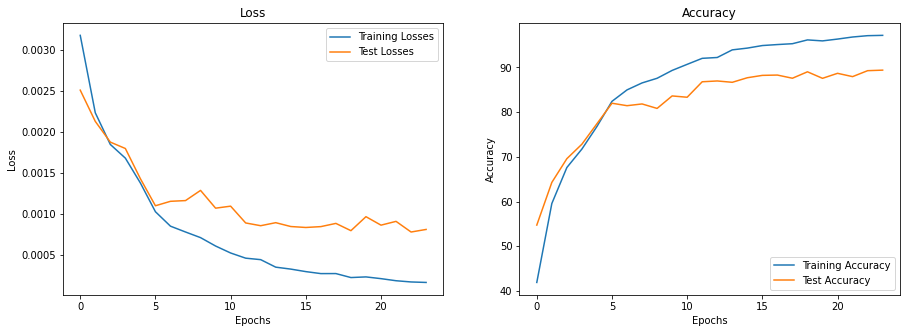

In [13]:
plot_acc_loss(train_acc,train_losses,test_acc,test_losses)

# Display wrong prediction

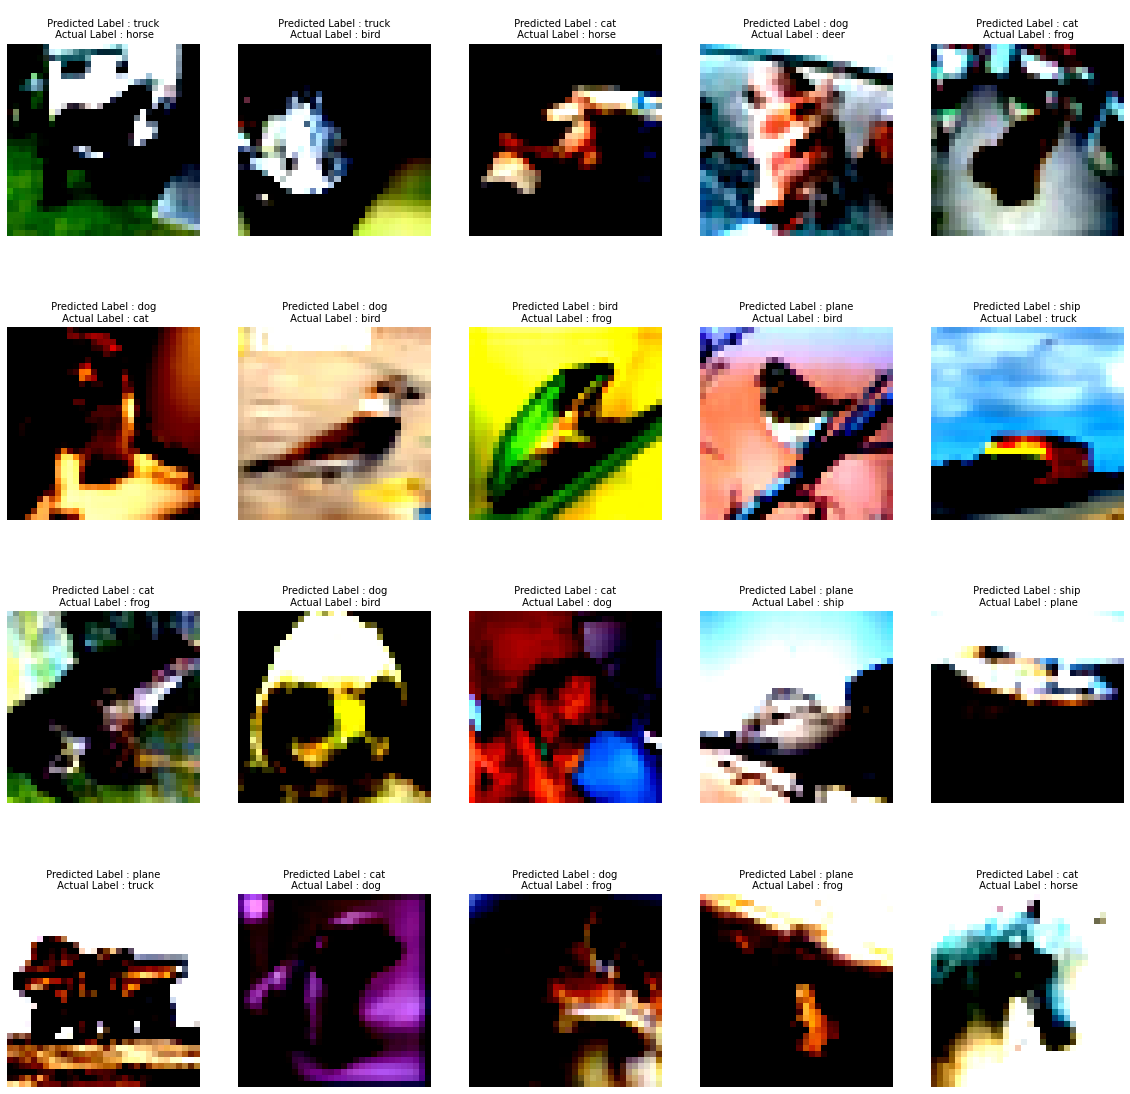

In [14]:
display_incorrect_pred(wrong_prediction_list)

# GradCam 

In [15]:
target_layers = ["layer1", "layer2","layer3"]
torch.autograd.set_detect_anomaly(True)

In [16]:
from main_repo.utils import generate_gradcam, plot_gradcam
gradcam_output, probs, predicted_classes = generate_gradcam(wrong_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


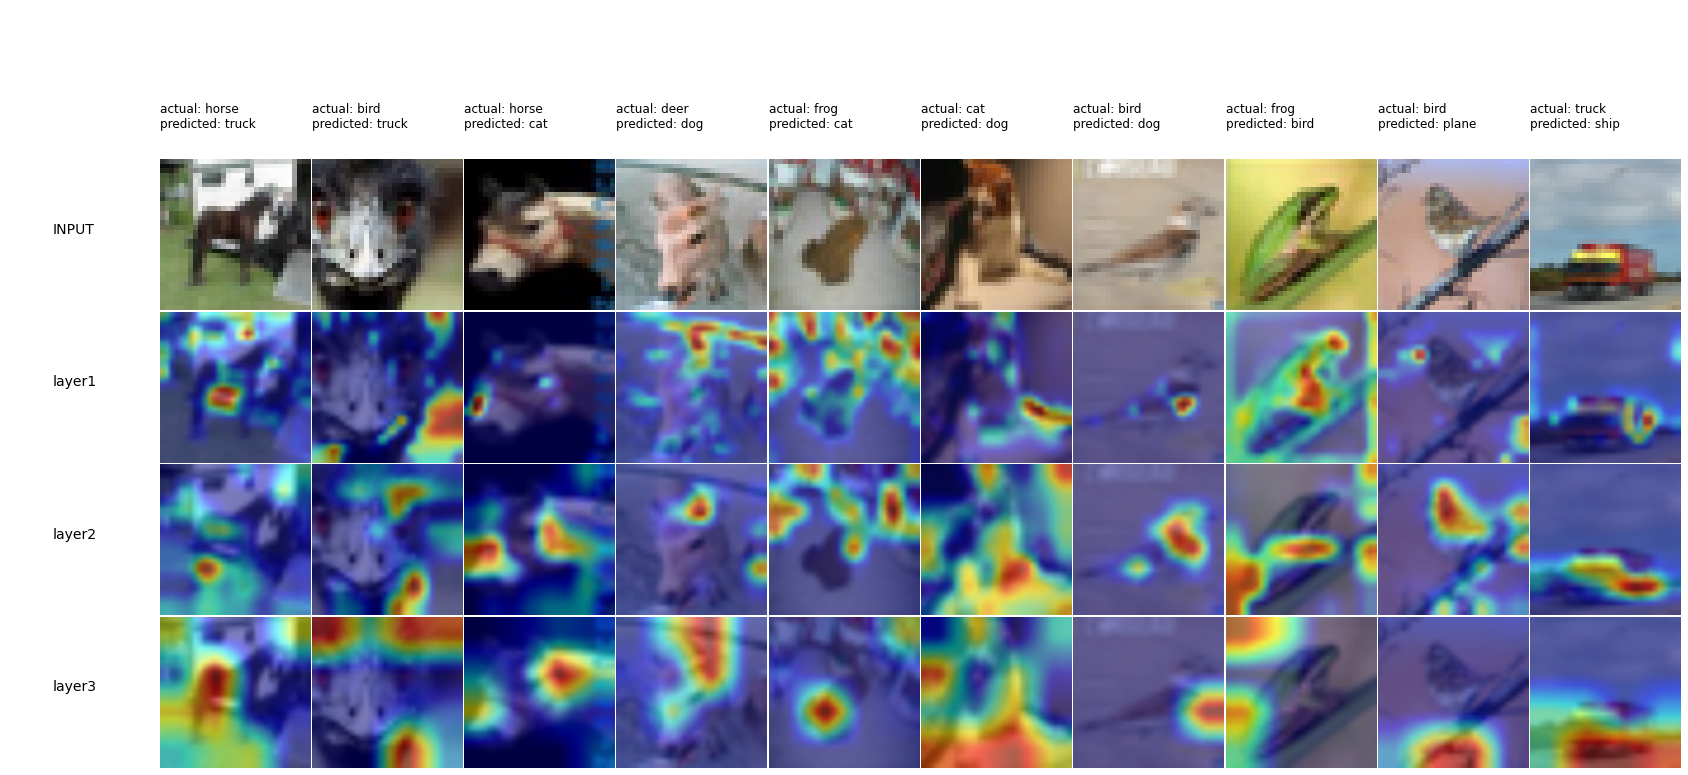

In [17]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, wrong_prediction_list[:10],mean,std)

In [18]:
gradcam_output, probs, predicted_classes = generate_gradcam(right_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


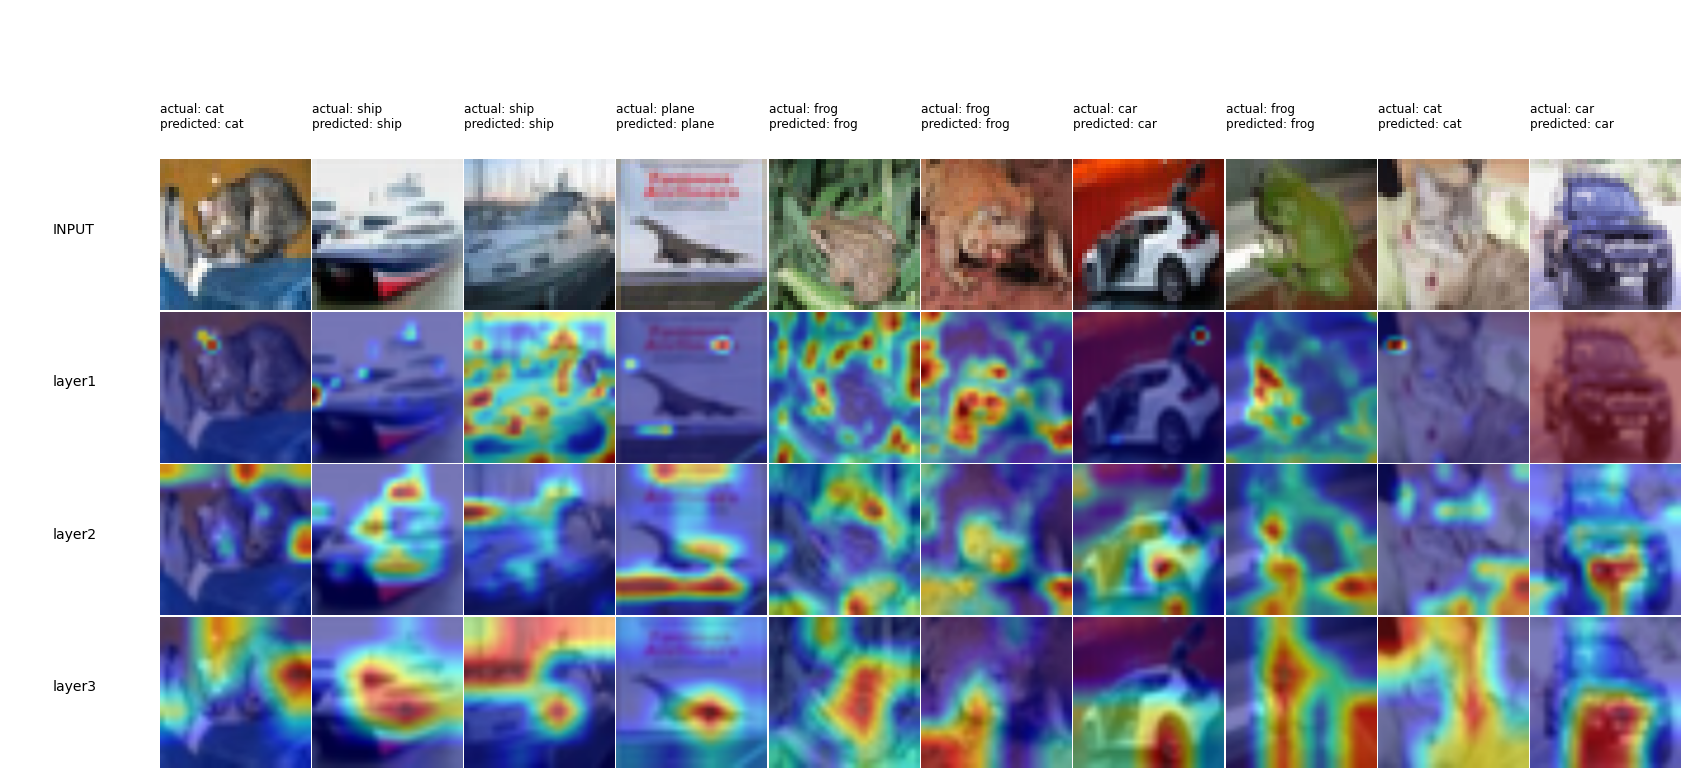

In [19]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, right_prediction_list[:10],mean,std)